In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import sqlite3
import statsmodels.api as sm
%matplotlib inline

## Read data using sql query

In [10]:
con = sqlite3.connect('data/nflPPdb.sqlite')
df1 = pd.read_sql_query('SELECT DISTINCT combine.name, rr.year, rr.rushing_yards, rr.receiving_yards, rr.games_played\
                        FROM combine, rr\
                        WHERE combine.name = rr.name AND combine.year < 2009', con)

df2 = pd.read_sql_query('SELECT combine.name, combine.fortyyd, \
                        combine.twentyss, combine.vertical, combine.picktotal, \
                        combine.heightinchestotal, combine.weight \
                        FROM combine\
                        WHERE combine.year < 2009 AND combine.pickround != 0', con)

df2['speedscore'] = (df2['weight']*200)/(df2['fortyyd']**4)
df2['BMI'] = 703.0 * df2['weight'] / df2['heightinchestotal']**2

df3 = pd.merge(df1, df2, on='name', how='inner', suffixes=('df1','df2'))
df4 = pd.read_sql_query('SELECT players.name, players.position\
                        FROM players', con)
df5 = pd.merge(df3,df4, on='name', how='inner', suffixes=('df3','df4'))
df5 = df5.drop_duplicates()
df5['totYds'] = (df5.receiving_yards + df5.rushing_yards)
# choose position of a player
df5 = df5[df5.position.isin(['RB'])]
#df5 = df5[df5.fortyyd < 5] #remove outlier

## Multivariable regression
### Performance

In [3]:
regdata = df5.groupby('name').head(3).reset_index(drop=True)
# duplicate regdata to get first three year sum
regdata_d = regdata
regdata = regdata.groupby('name').mean()
regdata_d = regdata_d.groupby('name').sum()
regdata['totYds'] = regdata_d['totYds']
regdata = regdata.dropna()

In [4]:
X = regdata[['weight','heightinchestotal','fortyyd','twentyss','vertical']]
Y = regdata['totYds']
X = sm.add_constant(X)
mod = sm.OLS(Y,X)

In [5]:
res = mod.fit()

In [6]:
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                 totYds   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     6.584
Date:                Tue, 15 Mar 2016   Prob (F-statistic):           2.17e-05
Time:                        10:57:40   Log-Likelihood:                -983.24
No. Observations:                 115   AIC:                             1978.
Df Residuals:                     109   BIC:                             1995.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const              2.911e+04   6751.82

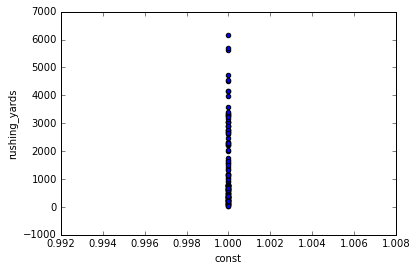

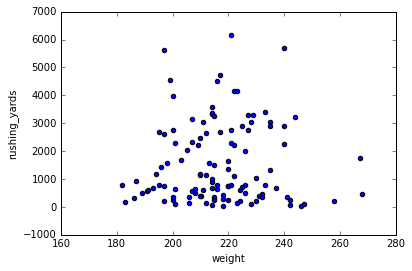

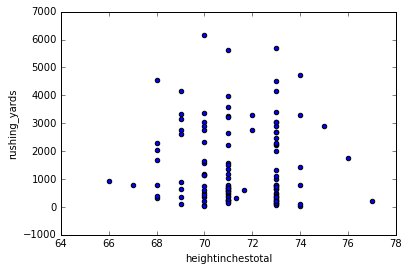

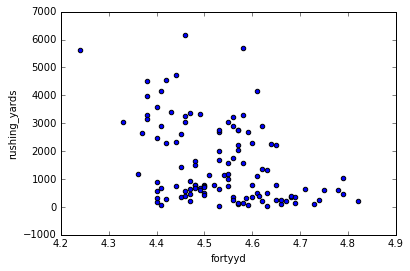

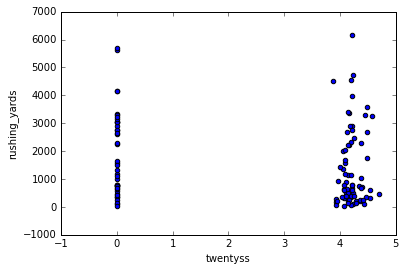

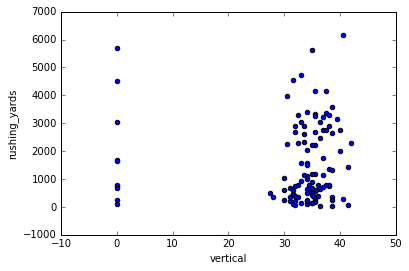

In [8]:
for column in X.columns:
    plt.scatter(X[column],Y)
    plt.xlabel(column)
    plt.ylabel('rushing_yards')
    plt.show(block=False)

### Total pick number

In [18]:
Y2 = regdata['picktotal']
mod3 = sm.OLS(Y2,X)
res3 = mod3.fit()
print res3.summary()

                            OLS Regression Results                            
Dep. Variable:              picktotal   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     20.40
Date:                Tue, 15 Mar 2016   Prob (F-statistic):           2.79e-08
Time:                        11:03:12   Log-Likelihood:                -630.25
No. Observations:                 115   AIC:                             1266.
Df Residuals:                     112   BIC:                             1275.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        423.8073     95.877      4.420      0.0

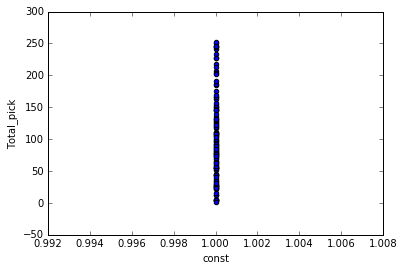

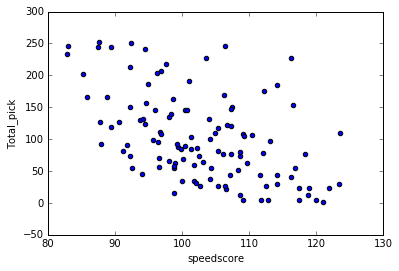

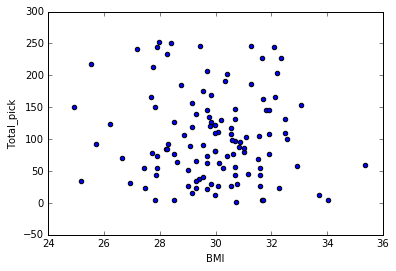

In [19]:
for column in X.columns:
    plt.scatter(X[column],Y2)
    plt.xlabel(column)
    plt.ylabel('Total_pick')
    plt.show(block=False)

In [11]:
X = regdata[['speedscore','BMI']]
Y = regdata['rushing_yards']
X = sm.add_constant(X)
mod2 = sm.OLS(Y,X)

In [12]:
res2 = mod2.fit()

In [13]:
xx1, xx2 = np.meshgrid(np.linspace(regdata['speedscore'].min(), regdata['speedscore'].max(), 100), 
                       np.linspace(regdata['BMI'].min(), regdata['BMI'].max(), 100))

In [14]:
Z = res2.params[0] + res2.params[1] * xx1 + res2.params[2] * xx2

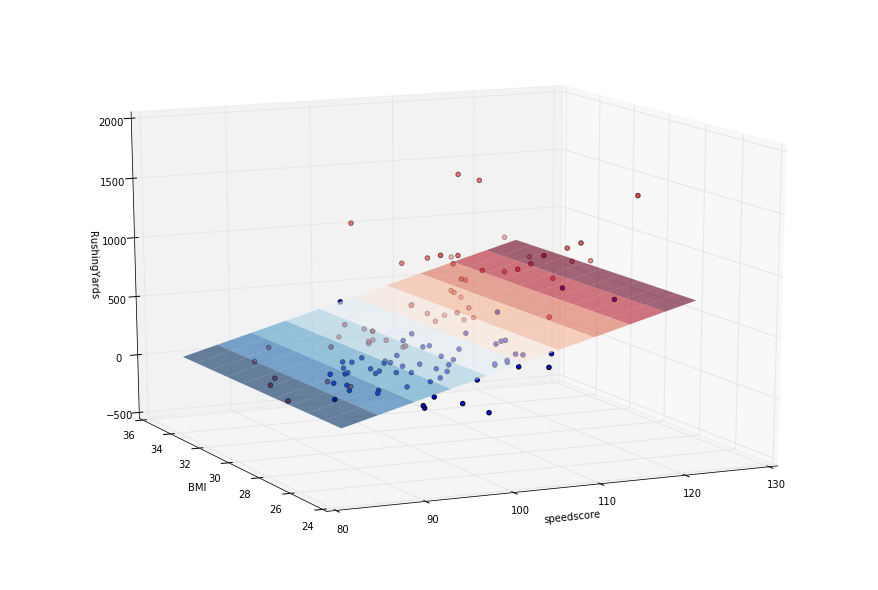

In [16]:
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-115, elev=15)
surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.6, linewidth=0)
resid = Y - res2.predict(X)
ax.scatter(X[resid >= 0]['speedscore'], X[resid >= 0]['BMI'], Y[resid >= 0], c='r',
            marker = 'o')
ax.scatter(X[resid < 0]['speedscore'], X[resid < 0]['BMI'], Y[resid < 0], color='black', alpha=1.0)
ax.set_xlabel('speedscore')
ax.set_ylabel('BMI')
ax.set_zlabel('RushingYards')